# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time, warnings
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
import re
from matplotlib import pyplot
warnings.filterwarnings("ignore")

# Load the Data

In [2]:
#load the data
retail_df = pd.read_csv('data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# Data Preparation

In [3]:
# UK Customers
retail_uk = retail_df[retail_df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

(495478, 8)

In [4]:
# remove canceled orders
retail_uk = retail_uk[retail_uk['Quantity']>0]
retail_uk.shape

(486286, 8)

In [5]:
#remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

(354345, 8)

In [6]:
#Find the Latest date
retail_uk['InvoiceDate'].max()

'9/9/2011 9:52'

In [7]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
retail_uk = retail_uk[retail_uk['InvoiceDate']>= "2010-09-09"]
retail_uk.shape

(176137, 8)

In [8]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_uk['InvoiceNo'].nunique())
print("Number of products bought: ",retail_uk['StockCode'].nunique())
print("Number of customers:", retail_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(retail_uk['CustomerID'].isnull().sum() * 100 / len(retail_df),2),"%" )

Summary..
Number of transactions:  8789
Number of products bought:  3294
Number of customers: 2864
Percentage of customers NA:  0.0 %


# 1-RFM Analysis

# Getting Recency

In [9]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [10]:
#Create a new column called date which contains the date of invoice only
retail_uk['date'] = pd.DatetimeIndex(retail_uk['InvoiceDate']).date
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105336,545220,48194,DOORMAT HEARTS,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105337,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,3/1/2011 8:30,1.65,14620,United Kingdom,2011-03-01
105338,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,3/1/2011 8:30,4.95,14620,United Kingdom,2011-03-01
105339,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,3/1/2011 8:30,3.75,14620,United Kingdom,2011-03-01


In [11]:
#Group by customers and check last date of purshace
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()

,CustomerID,LastPurshaceDate
0,12747,2011-08-22
1,12748,2011-09-30
2,12749,2011-08-01
3,12820,2011-09-26
4,12821,2011-05-09


In [12]:
#Calculate Recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)
recency_df.head()

,CustomerID,LastPurshaceDate,Recency
0,12747,2011-08-22,109
1,12748,2011-09-30,70
2,12749,2011-08-01,130
3,12820,2011-09-26,74
4,12821,2011-05-09,214


In [13]:
#Drop LastPurchaseDate coloum as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)
recency_df.head()

,CustomerID,Recency
0,12747,109
1,12748,70
2,12749,130
3,12820,74
4,12821,214


# Getting Frequency

In [14]:
# Drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)
# Calculate frequency of purchases
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12747,5
1,12748,96
2,12749,3
3,12820,1
4,12821,1


# Getting Monetary

In [15]:
# Create total cost column to each customer
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12747,191.85
1,12748,1054.43
2,12749,67.00
3,12820,15.00
4,12821,19.92


# Create RFM Table

In [16]:
temp_df = recency_df.merge(frequency_df,on='CustomerID')
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12747,109,5,191.85
1,12748,70,96,1054.43
2,12749,130,3,67.00
3,12820,74,1,15.00
4,12821,214,1,19.92


# RFM Table Verification

In [17]:
retail_uk[retail_uk['CustomerID']=='12747']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
106282,545321,20711,JUMBO BAG TOYS,20,3/1/2011 14:53,1.95,12747,United Kingdom,2011-03-01,39.00
175871,551992,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,5/5/2011 15:31,2.95,12747,United Kingdom,2011-05-05,17.70
203737,554549,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,48,5/25/2011 9:57,1.45,12747,United Kingdom,2011-05-25,69.60
241991,558265,22120,WELCOME WOODEN BLOCK LETTERS,3,6/28/2011 10:06,9.95,12747,United Kingdom,2011-06-28,29.85
308314,563949,21754,HOME BUILDING BLOCK WORD,6,8/22/2011 10:38,5.95,12747,United Kingdom,2011-08-22,35.70


In [18]:
(now - dt.date(2011,8,22)).days == 109

True

# 2-Customer Segments With RFM Model

# RFM Quartiles

In [19]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,85.0,1.0,16.35
0.50,119.0,2.0,35.40
0.75,183.0,3.0,92.42


In [20]:
quantiles.to_dict()

{'Recency': {0.25: 85.0, 0.5: 119.0, 0.75: 183.0},
 'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'Monetary': {0.25: 16.35, 0.5: 35.400000000000006, 0.75: 92.42000000000002}}

# Creation Of RFM Segment

In [21]:
# Arguments (x = value, p = Recency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = Monetary/Frequency, d = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [22]:
#Create RFM Segmentation Table
rfm_segmentation = rfm_df
rfm_segmentation['R'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [23]:
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12747,109,5,191.85,3,4,4
1,12748,70,96,1054.43,4,4,4
2,12749,130,3,67.00,2,3,3
3,12820,74,1,15.00,4,1,1
4,12821,214,1,19.92,1,1,2


In [24]:
# Combine the scores (R, F, M) Together
rfm_segmentation['RFMScore'] = rfm_segmentation.R.map(str) \
                            + rfm_segmentation.F.map(str) \
                            + rfm_segmentation.M.map(str)
rfm_segmentation.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMScore
0,12747,109,5,191.85,3,4,4,344
1,12748,70,96,1054.43,4,4,4,444
2,12749,130,3,67.00,2,3,3,233
3,12820,74,1,15.00,4,1,1,411
4,12821,214,1,19.92,1,1,2,112


In [25]:
def rfm_segment(x):
    if x == '444':
        return 'Best Customer'
    elif x == '111':
        return 'Lost Cheap Customer'
    elif x == '244':
        return 'Almost Lost Customer'
    elif x == '144':
        return 'Lost Customer'
    elif x == '141'or x =='142'or x =='241'or x =='242'or x =='243'or x =='342'or x =='343'or x =='143'or x =='341'or x =='441'or x =='442'or x =='344'or x =='443': 
        return 'Loyal Customer'
    elif x == '114'or x =='124'or x =='214'or x =='224'or x =='234'or x =='324'or x =='334'or x =='134'or x =='314'or x =='344'or x =='434'or x =='424': 
        return 'Big Spenders'
    elif x == '414' or x== '412' or x== '413' or x=='414': 
        return 'New Customer'
    else: 
        return 'Normal Customers'



In [26]:
rfm_segmentation['Segment'] = rfm_segmentation['RFMScore'].apply(rfm_segment)

In [27]:
rfm_plot=rfm_segmentation['Segment'].value_counts()
rfm_plot.head(8)

Normal Customers        1554
Loyal Customer           412
Lost Cheap Customer      278
Big Spenders             246
Best Customer            218
New Customer              99
Almost Lost Customer      52
Lost Customer              5
Name: Segment, dtype: int64

In [28]:
rfm_plot = pd.DataFrame({'Customer category': ['Normal Customers', 'Loyal Customer', 'Lost Cheap Customer', 'Big Spenders', 'Best Customer','New Customer','Almost Lost Customer','Lost Customer'],
                   'Total': [1554, 412, 278, 246, 218,99,52,5]})
rfm_plot.set_index('Customer category', inplace=True)
rfm_plot = rfm_plot.groupby('Customer category', axis=0).sum()
rfm_plot.head(8)

,Total
Customer category,
Almost Lost Customer,52
Best Customer,218
Big Spenders,246
Lost Cheap Customer,278
Lost Customer,5
Loyal Customer,412
New Customer,99
Normal Customers,1554


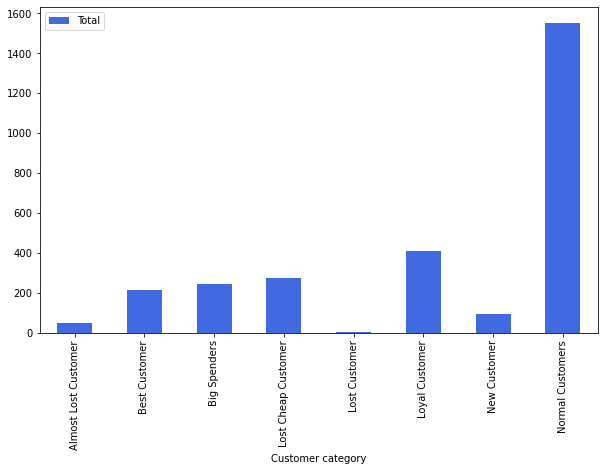

In [29]:
rfm_plot.plot(kind='bar', figsize=(10, 6), rot=90,color='royalblue')